In [ ]:
import pandas as pd
import numpy as np
import igraph as ig

# Import the city data.
raw = []
with open('input.txt','r') as f:
    for line in f:
        if line.strip()[0] != "#":
            raw.append(line.split())
            
n_cities = int(raw[0][0])
reliability_1d = np.asarray(raw[1], dtype='double')
cost_1d = np.asarray(raw[2], dtype='int')

# Convert the 1D matrices to 2D.
def convert_to_2d(size, arr1d):
    new_array = np.zeros((size, size))
    k = 0
    for i in range(0, size):
        for j in range(i + 1, size):
            new_array[i][j] = arr1d[k]
            k = k + 1
    return new_array

reliability = convert_to_2d(n_cities, reliability_1d)
cost = convert_to_2d(n_cities, cost_1d)

# Print matrices and extracted information.
print("Number of cities: " + str(n_cities))
print("Reliability matrix:")
print(reliability)
print("Cost matrix:")
print(cost)

# Create reliability graph.
graph = ig.Graph.Weighted_Adjacency(reliability).as_undirected()
graph.es["reliability"] = reliability_1d
graph.es["cost"] = cost_1d
graph.es["curved"] = [False for i in reliability_1d]
graph.vs["label"] = range(n_cities)

In [ ]:
# Create reliability graph.
# Create list of edges
def find_edges(size, arr2d):
    new_array = []
    k = 0
    for i in range(0, size):
        for j in range(i + 1, size):
            if (arr2d[i][j] != 0):
                new_array.append((i,j))
    return new_array

graph = ig.Graph()
graph.add_vertices(n_cities)
graph.add_edges(find_edges(n_cities,reliability))
graph.es['reliability'] = reliability_1d
graph.es["cost"] = cost_1d
graph.es["curved"] = [False for i in reliability_1d]
graph.vs["label"] = list(range(n_cities))

In [ ]:
# Plot reliability graph.
ig.plot(graph, edge_label=[str(r) for r in graph.es["reliability"]], vertex_label=[str(r) for r in graph.vs["label"]])

In [ ]:
# Plot cost graph.
ig.plot(graph, edge_label=[str(c) for c in graph.es["cost"]])

In [ ]:
# Find the MST (minimum spanning tree) using Kruskal's algorithm. 1 - r = u, so minimize unreliability.
mst_graph = graph.spanning_tree(weights=[1 - r for r in graph.es["reliability"]])

In [ ]:
# Plot the MST graph (optimized for minimum unreliability),
ig.plot(mst_graph, edge_label=[str(r) for r in mst_graph.es["reliability"]])

In [ ]:
# Compute cost and reliability for the MST.
import functools
import operator

mst_cost = sum(mst_graph.es["cost"])
# Since it's a minimum spanning tree, if any of the edges has failed, the entire system has failed.
mst_reliability = functools.reduce(operator.mul, mst_graph.es["reliability"])

print(f"The reliability of the MST is {mst_reliability:.3f} and its cost is {mst_cost}.")

In [ ]:
## Functions used for finding the reliability of a graph

# renames vertices when a vertice is deleted
def get_new_vertices(vertices, index):
    new_vertices = vertices.copy()
    for x in range(len(new_vertices)):
        if x > index:
            new_vertices[x] = new_vertices[x] - 1
    new_vertices.pop(index)
    return new_vertices
      
# removes edge from graph and returns new graph
def remove_edge(graph, edge, edge_ID):
    new_graph = graph.copy()
    new_graph.delete_edges(edge_ID)
    if (new_graph.degree(edge[0]) == 0):
        dead_vertice = edge[0]
        old_vertices = new_graph.vs["label"]
        new_graph.delete_vertices(dead_vertice)
        new_graph.vs["label"] = get_new_vertices(old_vertices, dead_vertice)
    elif (new_graph.degree(edge[1]) == 0):
        dead_vertice = edge[1]
        old_vertices = new_graph.vs["label"]
        new_graph.delete_vertices(dead_vertice)
        new_graph.vs["label"] = get_new_vertices(old_vertices, dead_vertice)
    return new_graph

# contracts vertices in graph and returns new graph
def contract_vertices(graph, edge):
    new_graph = graph.copy()
    vertices = new_graph.vs["label"].copy()
    dead_vertice = min(edge)
    surviving_vertice = max(edge)
    index_dead = vertices.index(dead_vertice)
    vertices[index_dead] = surviving_vertice
    new_graph.contract_vertices(vertices)
    new_graph.delete_edges([(surviving_vertice,surviving_vertice)])
    new_graph.delete_vertices(dead_vertice)
    new_graph.vs["label"] = get_new_vertices(vertices, index_dead)
    return new_graph
 
# returns True if deleting given edge does not disconnect the graph
#              if edge is not a self-loop
def is_valid_edge(graph, edge, edge_ID):
    valid = False
    test_graph = remove_edge(graph, edge, edge_ID)
    if (test_graph.is_connected() and edge[0] != edge[1]):
        valid = True
    return valid
    
# finds reliability by using edge decomposition recursively
def find_graphR(graph):
    vertice_count = graph.vcount();
    edge_count = graph.ecount();
    # when graph has one vertice with self-loops
    if (vertice_count == 1 and edge_count > 0):
        return 1
    # when graph is a tree (no loops)
    elif (graph.is_tree()):
        r = functools.reduce(operator.mul, graph.es["reliability"])
        return r
    # when graph has loops and more than one vertice
    elif (graph.is_connected()):
        edge_list = graph.get_edgelist()
        reliabilities = graph.es["reliability"].copy()
        for i,x in zip(range(len(edge_list)), edge_list):
            if is_valid_edge(graph, x, i):
                break
        dead_edge = x
        index_r = i
        r = reliabilities[index_r]
        dead_edge_ID = index_r
        graph_without_edge = remove_edge(graph, dead_edge, dead_edge_ID)
        graph_with_edge = contract_vertices(graph, dead_edge)
        return (1-r)*find_graphR(graph_without_edge) + r*find_graphR(graph_with_edge)
    # when error occurs
    else:
        print("algorithm failed because we deleted an edge that connects two different parts of the graph")
        return 0

In [ ]:
## Functions used for finding a graph that meets a given reliability goal.

# returns the edges that can be added to mst and related information
def find_remaining_edges(graph, mst):
    original_edge_list = graph.get_edgelist()
    original_reliabilty_list = graph.es["reliability"].copy()
    original_cost_list = graph.es["cost"].copy()
    original_curved_list = graph.es["curved"].copy()
    mst_edge_list = mst.get_edgelist()
    
    remaining_edge_list = original_edge_list.copy()
    indices = []
    for a in mst_edge_list:
        index = remaining_edge_list.index(a)
        remaining_edge_list.pop(index)
        indices.append(index)
        
    remaining_r_list = original_reliabilty_list.copy()
    remaining_cost_list = original_cost_list.copy()
    remaining_curved_list = original_curved_list.copy()
    for b in range(len(mst_edge_list)):
        remaining_r_list.pop(indices[b])
        remaining_cost_list.pop(indices[b])
        remaining_curved_list.pop(indices[b])
        
    return (remaining_edge_list, remaining_r_list, remaining_cost_list, remaining_curved_list)

# find new graph given target reliability and mst
def get_target_r(r_goal, graph, mst, r_result):
    new_reliability = 0
    info = find_remaining_edges(graph, mst)
    available_edge_list = info[0]
    available_r_list = info[1]
    available_cost_list = info[2]
    available_curved_list = info[3]
    new_graph = mst.copy()
    new_graph_r_list = new_graph.es["reliability"].copy()
    new_graph_cost_list = new_graph.es["cost"].copy()
    new_graph_curved_list = new_graph.es["curved"].copy()
    while len(available_r_list) > 0:
        max_r = max(available_r_list)
        index = available_r_list.index(max_r)
        new_edge = available_edge_list[index]
        new_cost = available_cost_list[index]
        new_curved = available_curved_list[index]
        new_graph.add_edges([new_edge])
        new_graph_r_list.append(max_r)
        new_graph_cost_list.append(new_cost)
        new_graph_curved_list.append(new_curved)
        new_graph.es["reliability"] = new_graph_r_list
        new_graph.es["cost"] = new_graph_cost_list
        new_graph.es["curved"] = new_graph_curved_list
        available_edge_list.pop(index)
        available_r_list.pop(index)
        available_cost_list.pop(index)
        available_curved_list.pop(index)
        new_reliability = find_graphR(new_graph)
        if new_reliability >= r_goal:
            r_result.append(new_reliability)
            return new_graph
    # this code executes if there is an error
    r_result.append(new_reliability)
    return new_graph

In [ ]:
## Test

r = []
new_graph = get_target_r(0.987, graph, mst_graph, r)

new_cost = sum(new_graph.es["cost"])

print(f"The reliability of the new graph is {r[0]} and its cost is {new_cost}")

# Plot reliability graph.
ig.plot(new_graph, edge_label=[str(r) for r in new_graph.es["reliability"]], vertex_label=[str(r) for r in new_graph.vs["label"]])

The reliability of the new graph is 0.994744


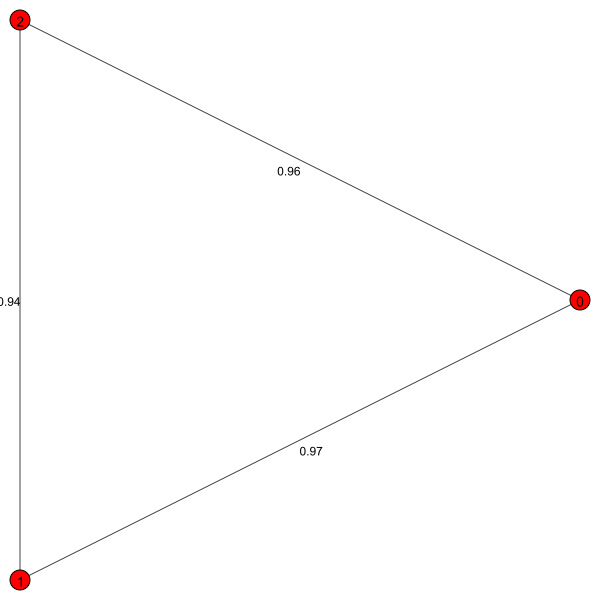

In [347]:
## Test

# Create reliability graph.
graph_test = ig.Graph()
graph_test.add_vertices(3)
graph_test.add_edges([(0,1),(0,2),(1,2)])
graph_test.es['reliability'] = [0.97,0.96,0.94]
graph_test.es["cost"] = [10,20,30]
graph_test.es["curved"] = [False, False, False]
graph_test.vs["label"] = [0,1,2]

final_r = find_graphR(graph_test)
print(f"The reliability of the graph is {final_r}")

# Plot reliability graph.
ig.plot(graph_test, edge_label=[str(r) for r in graph_test.es["reliability"]], vertex_label=[str(r) for r in graph_test.vs["label"]])